# Algorithm 1

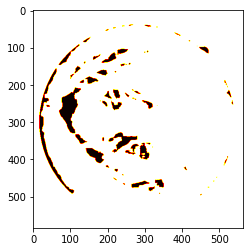

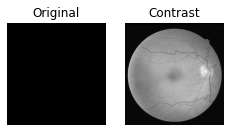

c:\users\swayt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:75: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


11287.252235412598 0.03643355896489291
Its a Retinal Image


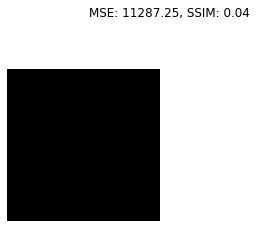

In [3]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#optimisation required
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np
import cv2

def adjust_gamma(image, gamma=1.0):
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

def extract_ma(image):
    r,g,b=cv2.split(image)
    comp=255-g
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    histe=clahe.apply(comp)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)

    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)

    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    plt.imshow(thresh2)

    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening


if __name__ == "__main__":
    fundus = cv2.imread("C:\\Users\\swayt\\Downloads\\DRIVE\\DRIVE\\DRIVE\\training\\training\\images\\21_training.tif")
    bloodvessel = extract_ma(fundus)
    original=bloodvessel

    #this image is for comparison
    contrast = cv2.imread("C:\\Users\\swayt\\Downloads\\DRIVE\\DRIVE\\DRIVE\\training\\training\\images\\22_training.tif")
    # convert the images to grayscale
   
    contrast = cv2.cvtColor(contrast, cv2.COLOR_BGR2GRAY)
    # initialize the figure
    fig = plt.figure("Images")
    images = ("Original", original), ("Contrast", contrast)
    # loop over the images
    for (i, (name, image)) in enumerate(images):
        # show the image
        ax = fig.add_subplot(1, 3, i + 1)
        ax.set_title(name)
        plt.imshow(image, cmap = plt.cm.gray)
        plt.axis("off")
    # show the figure
    plt.show()
    
    width = 512
    height = 512
    dim = (width, height)
    
    original=cv2.resize(original,dim,interpolation = cv2.INTER_AREA)
    contrast=cv2.resize(contrast,dim,interpolation = cv2.INTER_AREA)
    err = np.sum((original.astype("float") - contrast.astype("float")) ** 2)
    err /= float(original.shape[0] * original.shape[1])
    m = err
    s = measure.compare_ssim(original, contrast)

    fig = plt.figure("MSE PLOT")
    print(m,s)


    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(original, cmap = plt.cm.gray)
    plt.axis("off")
    
    if(m>0.1 and s<1):
        print("Its a Retinal Image")
    else:
        print("Not Retinal Image")


# Algorithm 2

In [ ]:
import cv2;
import numpy as np;
from pylab import array, uint8,arange;
from matplotlib import pyplot as plt

img = cv2.imread("C:\\Users\\swayt\\Downloads\\DRIVE\\DRIVE\\DRIVE\\training\\training\\images\\25_training.tif");
input = cv2.imread("C:\\Users\\swayt\\Downloads\\DRIVE\\DRIVE\\DRIVE\\training\\training\\images\\25_training.tif");

green = img[:,:,1]
g_inv = cv2.bitwise_not(green)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl_img = clahe.apply(g_inv)


kernel = np.ones((51,51),np.uint8)
kernel_small = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(cl_img, cv2.MORPH_OPEN, cv2.getStructuringElement( cv2.MORPH_ELLIPSE,(91,91)))

godisk = cv2.subtract(cl_img,opening)
kernel_tiny = np.ones((2,2),np.uint8)
erode1  = cv2.erode(godisk,kernel_small)
dilate1  = cv2.dilate(erode1,kernel_tiny)
med_img  = cv2.medianBlur(godisk,13);

kernel2 = np.ones((91,91),np.uint8)
background = cv2.morphologyEx(med_img, cv2.MORPH_OPEN, kernel2)
I2 = cv2.subtract(med_img,background)

# equalize the histogram of the Y channel
eq_I2 = cv2.equalizeHist(I2)

ret,thr = cv2.threshold(eq_I2,238,255,cv2.THRESH_BINARY)

kernel = np.ones((3,3), 'uint8')
dil = cv2.dilate(thr, kernel)  
cv2.namedWindow("BV",cv2.WINDOW_NORMAL);
cv2.imshow("BV",dil)

contours, hierarchy = cv2.findContours(thr,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
mask = np.ones(dil.shape[:2], dtype="uint8") * 255

connectivity = 4  
# Perform the operation
output = cv2.connectedComponentsWithStats(dil, connectivity, cv2.CV_32S)
# Get the results
# The first cell is the number of labels
num_labels = output[0]
# The second cell is the label matrix
labels = output[1]
# The third cell is the stat matrix
stats = output[2]

area1 = stats[labels, cv2.CC_STAT_AREA]
print(area1);
print(len(output))

for cnt in contours:
    #area = cv2.arcLength(cnt,True)
    area=len(cnt);
    
    if area < 50:
        ctr = np.array(cnt).reshape((-1,1,2)).astype(np.int32)
        cv2.drawContours(mask, [ctr], -1, 0, -1)

# remove the contours from the image and show the resulting images
dil = cv2.bitwise_and(dil, dil, mask=mask)

cv2.drawContours(img,contours,-1,(0,255,0),3)
cv2.namedWindow("Blood_Vessels_overlapped",cv2.WINDOW_NORMAL);
cv2.imshow("Blood_Vessels_overlapped",img)
cv2.waitKey(0);

[[308096 308096 308096 ... 308096 308096 308096]
 [308096 308096 308096 ... 308096 308096 308096]
 [308096 308096 308096 ... 308096 308096 308096]
 ...
 [308096 308096 308096 ... 308096 308096 308096]
 [308096 308096 308096 ... 308096 308096 308096]
 [308096 308096 308096 ... 308096 308096 308096]]
4


# Algorithm 3

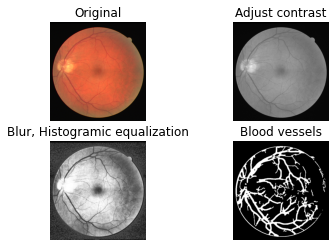

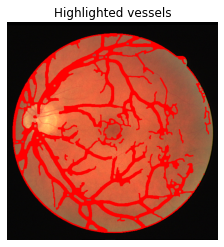

In [13]:
import skimage
import cv2
from skimage import data, io, filters, exposure, feature, img_as_float, exposure
from skimage.morphology import square, dilation, erosion
from matplotlib import pyplot as plt
from PIL import Image
from os.path import abspath, exists
import numpy as np

#nazwa pliku oraz maski
FILE = "C:\\Users\\swayt\\Downloads\\DRIVE (1)\\DRIVE\\test\\images\\12_test.tif"
FILE_MASK = "C:\\Users\\swayt\\Downloads\\DRIVE (1)\\DRIVE\\test\\1st_manual\\12_manual1.gif"

#stworzenie planu
fig = plt.figure()

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.set_title("Original")
ax2.set_title("Adjust contrast")
ax3.set_title("Blur, Histogramic equalization")
ax4.set_title("Blood vessels")

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
#wczytanie obrazu
img_src = cv2.imread(FILE)
ax1.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))

#wczytanie maski
img_mask = cv2.imread(FILE_MASK,0)

height = img_src.shape[0]
width = img_src.shape[1]

#wczytanie obrazu w skali szarosci
img_gray = cv2.imread(FILE,0)

#zwiekszenie kontrastu 105
img_rescale = exposure.rescale_intensity(img_gray, in_range=(0,285))
ax2.imshow(img_rescale, cmap="gray")

#rozmycie
blur = cv2.blur(img_rescale,(2,3)) 

#normalizacja histogramu
equ = cv2.equalizeHist(blur)
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
cl1 = clahe.apply(equ)
ax3.imshow(cl1, cmap="gray")

#detekcja krawedzi
image = img_as_float(cl1)
image = feature.canny(image, sigma=2)

#filtracja pixeli na podstawie czerwieni
for i in range(0,height):
    for j in range(0,width):
        if(image[i][j]==True):
            if(img_src[i][j][2]<125):
                image[i][j]=False

#dylatacja 29
image = dilation(image, square(7))

#erozja 22
image = erosion(image,square(5))
ax4.imshow(image, cmap="gray")

#wyswietlenie planu
plt.show()

#stworzenie nowego planu
fig2 = plt.figure()
bx1 = fig2.add_subplot(1,1,1)

#pokrywanie oryginalnego obrazu naczyniami krwionosnymi
for i in range(0,height):
    for j in range(0,width):
        if(image[i][j]==True):
           img_src[i][j][0] = 0
           img_src[i][j][1] = 0
           img_src[i][j][2] = 255
           
bx1.imshow(cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB))
bx1.set_title('Highlighted vessels')
bx1.axis('off')
plt.show()


# Algorithm 4

In [5]:
import cv2
import numpy as np

# This is coded separately from the function from the other file because adding a conditional regarding plotting
# logic would slow down the code, which would not be ideal for this use case.

# Parameter 45
THRESHOLD = 45
IMAGE_FILE_NAME = 'C:\\Users\\swayt\\Downloads\\Training (1) (extract.me)\\Training\\dr_52.png'

# Read in image and transform it
im = cv2.imread(IMAGE_FILE_NAME)
#cv2.imshow('Original', im)
im_grey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#cv2.imshow('Grey', im_grey)

# Inverting the image to highlight the areas of interest since they are dark
# Note: This is not actually required/used by Canny
im_mod = cv2.bitwise_not(im_grey)
#cv2.imshow('Inverted', im_mod)

# Detect edges using Canny
# Typically you would blur (i.e. im_mod = cv2.blur(im_mod, (3,3))), but in this case it performs worse
# This is taken from the OpenCV demo https://docs.opencv.org/3.4/df/d0d/tutorial_find_contours.html
canny_output = cv2.Canny(im_grey, THRESHOLD, THRESHOLD * 2)

# Find all shapes
contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw the shapes on the images for reference
drawing = np.zeros((im_grey.shape[0], im_grey.shape[1], 3), dtype=np.uint8)
color = (0, 0, 255)
for i in range(len(contours)):
    cv2.drawContours(drawing, contours, i, color, 2, cv2.LINE_8, hierarchy, 0)
    cv2.drawContours(im, contours, i, color, 2, cv2.LINE_8, hierarchy, 0)
cv2.imshow('Detected', drawing)
cv2.imshow('Detected Superimposed on Original', im)

# Print the number of shapes it found
print('Num Detected Shapes:', len(contours))

cv2.waitKey(0)
cv2.destroyAllWindows()

Num Detected Shapes: 184


# Algorithm 5

c:\users\swayt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:103: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


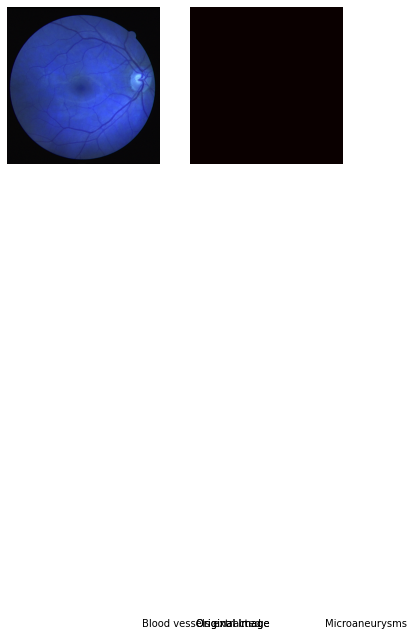

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

######Blood vessel extraction#######
def extract_bv(image):		
	b,green_fundus,r = cv2.split(image)
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	contrast_enhanced_green_fundus = clahe.apply(green_fundus)

	r1 = cv2.morphologyEx(contrast_enhanced_green_fundus, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
	r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)), iterations = 1)
	r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)
	R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(23,23)), iterations = 1)	
	f4 = cv2.subtract(R3,contrast_enhanced_green_fundus)
	f5 = clahe.apply(f4)
	bloodvessel="aa"
	# removing very small contours through area parameter noise removal
	ret,f6 = cv2.threshold(f5,15,255,cv2.THRESH_BINARY)	
	mask = np.ones(f5.shape[:2], dtype="uint8") * 255	
	im2, contours, hierarchy = cv2.findContours(f6.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
	for cnt in contours:
		if cv2.contourArea(cnt) <= 200:
			cv2.drawContours(mask, [cnt], -1, 0, -1)			
	im = cv2.bitwise_and(f5, f5, mask=mask)
	ret,fin = cv2.threshold(im,15,255,cv2.THRESH_BINARY_INV)			
	newfin = cv2.erode(fin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations=1)	

	# removing blobs of unwanted bigger chunks taking in consideration they are not straight lines like blood vessels and also in an interval of area
	fundus_eroded = cv2.bitwise_not(newfin)	
	xmask = np.ones(fundus.shape[:2], dtype="uint8") * 255
	x1, xcontours, xhierarchy = cv2.findContours(fundus_eroded.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)	
	for cnt in xcontours:
		shape = "unidentified"
		peri = cv2.arcLength(cnt, True)
		approx = cv2.approxPolyDP(cnt, 0.04 * peri, False)   				
		if len(approx) > 4 and cv2.contourArea(cnt) <= 3000 and cv2.contourArea(cnt) >= 100:
			shape = "circle"	
		else:
			shape = "veins"
		if(shape=="circle"):
			cv2.drawContours(xmask, [cnt], -1, 0, -1)	
	
	finimage = cv2.bitwise_and(fundus_eroded,fundus_eroded,mask=xmask)	
	blood_vessels = cv2.bitwise_not(finimage)
	return blood_vessels	

if __name__ == "__main__":	
		fundus = cv2.imread("C:\\Users\\swayt\\Downloads\\DRIVE (1)\\DRIVE\\training\\images\\35_training.tif")
		plt.subplot(1,2,1)
		plt.imshow(fundus)

		plt.axis('off')
		plt.text(700, 2300, r'Original Image')
		
		
		#cv2.imwrite("_bloodvessel.png",bloodvessel)
		#plt.subplot(1,2,2)
		#cv2.imshow("bv",bloodvessel)
		#plt.set_cmap('hot')
		
		plt.axis('off')
		plt.text(500, 2300, r'Blood vessels extracted')
		

######## MICROANEURYSM #########
def adjust_gamma(image, gamma=1.0):

   
   table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)
def extract_ma(image):
    r,g,b=cv2.split(image)
    comp=255-g
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    histe=clahe.apply(comp)
    adjustImage = adjust_gamma(histe,gamma=3)
    comp = 255-adjustImage
    J =  adjust_gamma(comp,gamma=4)
    J = 255-J
    J = adjust_gamma(J,gamma=4)
    
    K=np.ones((11,11),np.float32)
    L = cv2.filter2D(J,-1,K)
    
    ret3,thresh2 = cv2.threshold(L,125,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
    kernel2=np.ones((9,9),np.uint8)
    tophat = cv2.morphologyEx(thresh2, cv2.MORPH_TOPHAT, kernel2)
    kernel3=np.ones((7,7),np.uint8)
    opening = cv2.morphologyEx(tophat, cv2.MORPH_OPEN, kernel3)
    return opening




if __name__ == "__main__":
    fundus = cv2.imread("C:\\Users\\swayt\\Downloads\\DRIVE (1)\\DRIVE\\training\\images\\29_training.tif")
    bloodvessel = extract_ma(fundus)
    plt.subplot(1,2,1)
    plt.imshow(fundus)
    plt.set_cmap('inferno')

    plt.axis('off')
    plt.text(700, 2300, r'Original Image')
		
    cv2.imwrite("microaneurysms.png",bloodvessel)
    plt.subplot(1,2,2)
    plt.axis('off')

    plt.imshow(bloodvessel)
    plt.set_cmap('hot')
    plt.text(500, 2300, r'Microaneurysms')

    cv2.imwrite("ma.png",bloodvessel)
    plt.show()